# Avaliação Final

Neste notebook você vai colocar em pratíca a manupulação de dados, gráficos e análises.

# Conjunto de dados de previsão de insuficiência cardíaca

As doenças cardiovasculares (DCV) são a causa número 1 de morte em todo o mundo, tirando cerca de 17,9 milhões de vidas a cada ano, o que representa 31% de todas as mortes em todo o mundo. Quatro em cada 5 mortes por DCV são devidas a ataques cardíacos e derrames, e um terço dessas mortes ocorre prematuramente em pessoas com menos de 70 anos de idade. A insuficiência cardíaca é um evento comum causado por DCVs e este conjunto de dados contém 11 recursos que podem ser usados para prever uma possível doença cardíaca.

Pessoas com doenças cardiovasculares ou com alto risco cardiovascular (devido à presença de um ou mais fatores de risco, como hipertensão, diabetes, hiperlipidemia ou doença já estabelecida) precisam de detecção e tratamento precoces, nos quais um modelo de aprendizado de máquina pode ser de grande ajuda.

**Baixando os dados**

1.   Na pasta do cursto: https://drive.google.com/file/d/1P4LBAgv0vZl_aELcI8k6ZO_pz0otPaRl/view?usp=sharing
2.   No Kaggle: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction




## Entendendo as variáveis do dataset

* **Age**: idade do paciente (em anos).
* **Sex**: sexo do paciente.
    * `M`: Masculino
    * `F`: Feminino
* **ChestPainType**: tipo de dor toracíca.
    * `TA`: Angina típica
    * `ATA`: Angina atípica
    * `NAP`: Dor não anginosa
    * `ASY`: Assintomática
* **RestingBP**: pressão arterial em repouso (em mm Hg).
* **Cholesterol**: colesterol sérico (em mm/dl).
* **FastingBS**: açúcar no sangue em jejum.
    * `1`: se o açúcar no sangue em jejum for maior que 120 mg/dl.
    * `0`: caso contrário.
* **RestingECG**: resultados do eletrocardiograma de repouso.
    * `Normal`: Normal
    * `ST`: Anormalidade da onda ST-T (inversões da onda T e/ou supradesnivelamento ou depressão do segmento ST de > 0,05 mV).
    * `HVE`: Hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes.
* **MaxHR**: frequência cardíaca máxima alcançada (valor numérico entre 60 e 202).
* **ExerciseAngina**: angina induzida por exercício.
    * `Y`: Sim
    * `N`: Não
* **Oldpeak**: oldpeak = ST (valor numérico medido em depressão).
* **ST_Slope**: a inclinação do segmento ST do exercício de pico.
    * `Up`: Inclinação ascendente (`upsloping`)
    * `Flat`: Plano (`flat`)
    * `Down`: Inclinação descendente (`downsloping`)
* **HeartDisease**: classe de saída que indica a presença de doença cardíaca.
    * `1`: Doença cardíaca
    * `0`: Normal   



## Carregar dados

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

df_raw = pd.read_csv('data/heart.csv')
print("\nPrimeiras linhas do conjunto de dados:")
display(df_raw.head(10))


Primeiras linhas do conjunto de dados:


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


## Preparação dos dados  

Vamos treinar um modelo capaz de fazer predições se um paciente tem uma doença cardíaca ou não.

## Divisão de dados

In [2]:
# Agrupar dados aleatoriamente
# A variavel porcent_test define quantos porcento dos dados são para teste
# Nesse caso, 20% dos dados são para teste e 80% para treinamento.
porcent_test = 0.2
# Usamos random_state=42 para garantir reprodutibilidade
df_test = df_raw.sample(frac=porcent_test, random_state=42)
mask = df_raw.apply(tuple, 1).isin(df_test.apply(tuple, 1))

# Remove essas linhas do DataFrame original
df = df_raw[~mask].reset_index(drop=True)

# Calculando a porcentagem dos dados para cada conjunto
porcentagem_treinamento = (len(df) / len(df_raw)) * 100
porcentagem_teste = (len(df_test) / len(df_raw)) * 100

print(f"Dataset Original: {df_raw.shape}")
print(f"Dataset de Treinamento: {df.shape} ({porcentagem_treinamento:.2f}%)")
print(f"Dataset Final de Teste: {df_test.shape} ({porcentagem_teste:.2f}%)")
print(f"\n\nNúmero de amostras por classe:")
df['HeartDisease'].value_counts()


Dataset Original: (918, 12)
Dataset de Treinamento: (734, 12) (79.96%)
Dataset Final de Teste: (184, 12) (20.04%)


Número de amostras por classe:


HeartDisease
1    401
0    333
Name: count, dtype: int64

## Métrica de avaliação técnica

In [3]:
# Importa as bibliotecas necessárias para a construção do modelo
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np


def evaluate_classification(y, y_pred):
    # Primeira parte
    accuracy = accuracy_score(y, y_pred)
    print(f'Acurácia: {accuracy}')

    # Segunda parte
    print('Relatório de Classificação:')
    print(classification_report(y, y_pred))

    # Terceira parte
    conf_matrix = confusion_matrix(y, y_pred)
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
                xticklabels=['Sem doença', 'Com doença'], yticklabels=['Sem doença', 'Com doença'])
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão')
    plt.show()

    # Retorna o valor da acurácia
    return accuracy

# Análise exploratória

## Questão 1: faça um histograma da variável '**Cholesterol**'

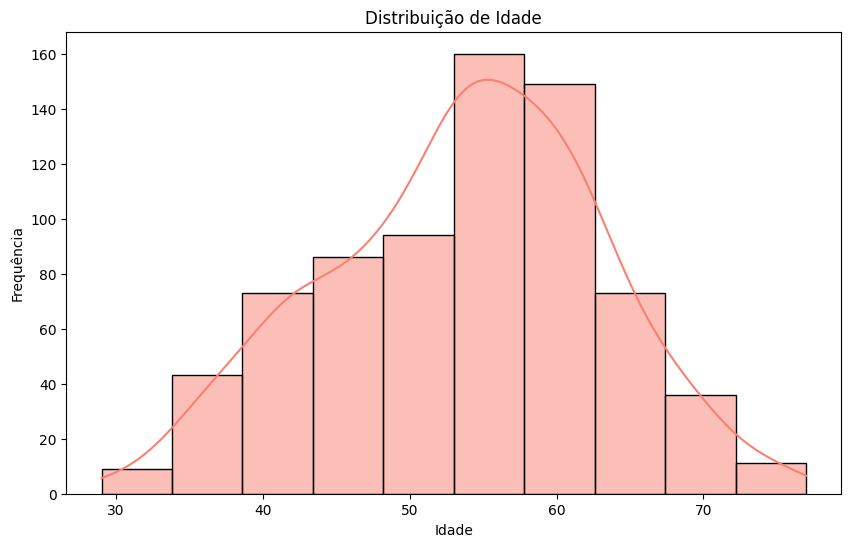

In [10]:
# Criando o histograma da coluna 'Age'
# Complete o código abaixo para fazer o histograma, substitua onde tem '____'
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Age', bins=10, kde=True, color='salmon')
plt.title('Distribuição de Idade')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.show()

## Questão 2: Faça um gráfico de barras da variável '**ChestPainType**'

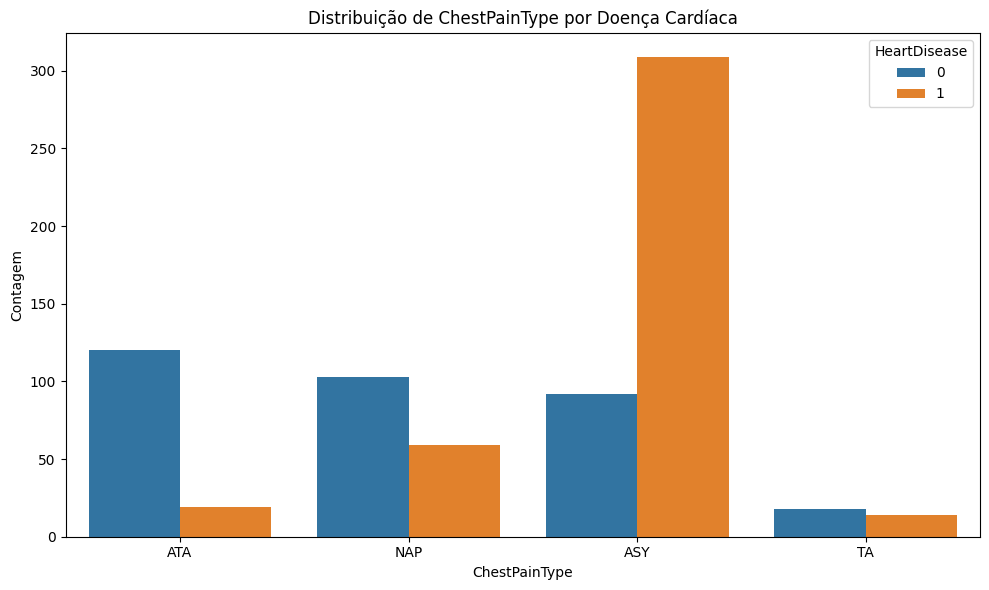

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='ChestPainType', hue='HeartDisease')
plt.title('Distribuição de ChestPainType por Doença Cardíaca')
plt.xlabel('ChestPainType')
plt.ylabel('Contagem')

plt.tight_layout()
plt.show()

## Questão 3: faça um boxplot da variável 'Age'

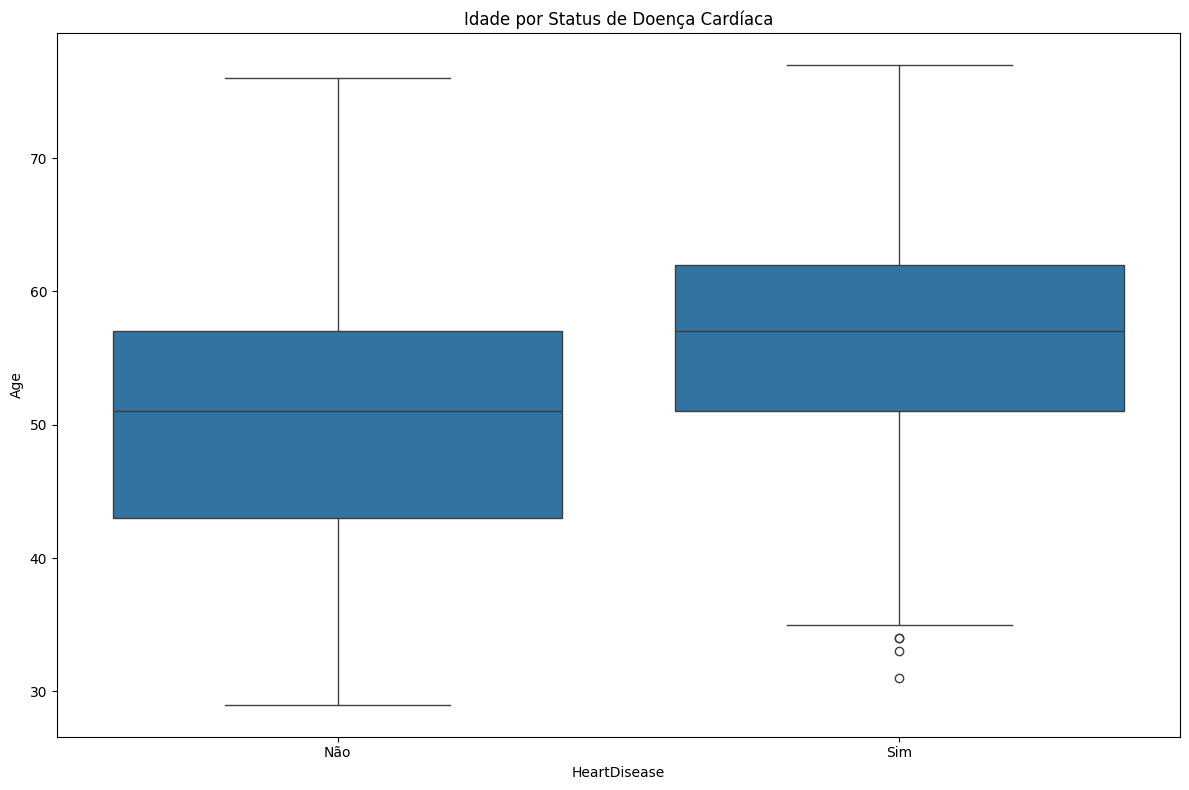

In [12]:
# Criando o boxplot da coluna 'Age'
# Complete o código abaixo para fazer o boxplot da variável Age, substitua onde tem '____'

plt.figure(figsize=(12, 8))

sns.boxplot(x='HeartDisease', y='Age', data=df)
plt.title('Idade por Status de Doença Cardíaca')
# Personaliza os rótulos do eixo x
plt.xticks([0, 1], ['Não', 'Sim'])

plt.tight_layout()
plt.show()

## Questão 4: Faça análise com suas palavras do resultado dos gráficos 

## Questão 5: Escolha uma variável para fazer seu modelo simples baseado em regras. Por que escolheu ela? 

In [ ]:
"""
Voce deve esolher uma variável para servir de base para o seu modelo baseado em regras. 
Além de esolher a variável, observe que tambem é necessária a escolha de uma categoria dessa variável.
"""
# Preencha onde tem "______"
variavel_escolhida = 'ChestPainType'
categoria_da_variavel = 'ASY'

### Visualizando o resultado (não é necessário alterar nada nessa etapa)

Preparando os dados

In [ ]:
# Seleciona as características e o alvo
X = df.drop(['HeartDisease'], axis=1) # tudo menos o alvo
y = df['HeartDisease'] # o que queremos prever (o alvo)

A função `predict_by_pain_type` cria um modelo baseado na variável que voce escolheu. 
Como ela funciona? Basicamente se o paciente tiver a variável escolhida na categoria escolhida, o modelo preve ele como doente. Caso contrário, o paciente é previsto como saudável (sem doença).

Acurácia: 0.7493188010899182
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       333
           1       0.77      0.77      0.77       401

    accuracy                           0.75       734
   macro avg       0.75      0.75      0.75       734
weighted avg       0.75      0.75      0.75       734



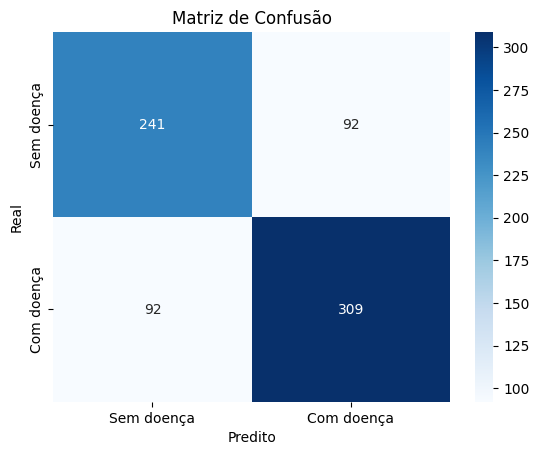

In [ ]:
# Cria predições com base na regra escolhida
def predict_by_pain_type(df):
    predictions = []
    for _, patient in df.iterrows():
        if (patient[variavel_escolhida] == categoria_da_variavel): # Se o paciente tiver tiver variavel_escolhida = categoria_da_variavel...
            predictions.append(1)  # Prediz com doença
        else:
            predictions.append(0)  # Prediz sem doença
    return predictions

# Gera as predições
y_pred_pain_type = predict_by_pain_type(df)

# Avalia as predições e salva o valor da acurácia
acc_regras = evaluate_classification(y, y_pred_pain_type)

## Regressão Logística

Vamos criar um modelo de regressão logística e avaliá-lo em relação ao modelo de base.

A **regressão logística** é um algoritmo de aprendizado de máquina supervisionado utilizado para tarefas de classificação, onde o objetivo é prever a probabilidade de que uma instância pertença a uma determinada classe.

É amplamente utilizado para problemas de classificação binária, onde a saída é uma variável categórica com dois valores possíveis, como 0 ou 1, que é o nosso caso.

--------------
Acurácia: 0.8569482288828338
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       333
           1       0.86      0.88      0.87       401

    accuracy                           0.86       734
   macro avg       0.86      0.85      0.86       734
weighted avg       0.86      0.86      0.86       734



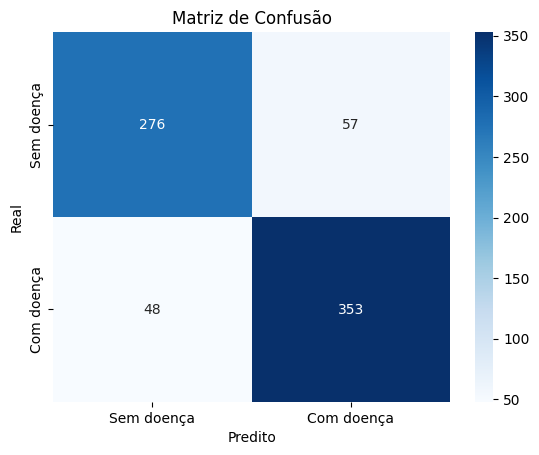

In [26]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# -----------------------------
# 1) Seleção de features e alvo
# -----------------------------
features = [
    'Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol',
    'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina',
    'Oldpeak', 'ST_Slope'
]
X = df[features].copy()
y = df['HeartDisease'].copy()

# -----------------------------
# 2) Lidar com valores nulos
# -----------------------------
# Numéricas -> mediana
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
num_imputer = SimpleImputer(strategy='median')
X[num_cols] = num_imputer.fit_transform(X[num_cols])

# Categóricas -> modo (mais frequente)
cat_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
for c in cat_cols:
    X[c] = X[c].fillna(X[c].mode()[0])

# -----------------------------
# 3) Codificar categóricas 
# -----------------------------
encoders = {}
for c in cat_cols:
    le = LabelEncoder()
    X[c] = le.fit_transform(X[c])
    encoders[c] = le  # guarda se precisar inverter depois

# -----------------------------
# 4) Normalização (Min-Max) nos numéricos
# -----------------------------
scaler = MinMaxScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# -----------------------------
# 5) Modelo: Regressão Logística
# -----------------------------
model_lr = LogisticRegression(random_state=42, max_iter=1000)
model_lr.fit(X, y)

# -----------------------------
# 6) Predição e avaliação
# -----------------------------
y_pred_lr = model_lr.predict(X)

print('--------------')
acc_lr = evaluate_classification(y, y_pred_lr)


### Importancia das variáveis

In [27]:
model_lr.coef_

array([[ 0.8116815 ,  1.16854905, -0.59107649,  0.31279176, -1.83644007,
         0.94703999, -0.20450944, -0.86678779,  1.30619163,  1.87913843,
        -1.76274316]])

In [28]:
# Imprimi a importância das características
feature_importance_lr = pd.DataFrame({
    'Feature': features,
    'Coefficient': abs(model_lr.coef_[0])
})
print("\nImportância das Características:")
print(feature_importance_lr.sort_values('Coefficient', ascending=False))


Importância das Características:
           Feature  Coefficient
9          Oldpeak     1.879138
4      Cholesterol     1.836440
10        ST_Slope     1.762743
8   ExerciseAngina     1.306192
1              Sex     1.168549
5        FastingBS     0.947040
7            MaxHR     0.866788
0              Age     0.811682
2    ChestPainType     0.591076
3        RestingBP     0.312792
6       RestingECG     0.204509


### Comparação com os outros modelos 

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_model_comparison(resultados):

    # Cria um DataFrame a partir do dicionário
    df_resultados = pd.DataFrame(resultados.items(), columns=['Modelo', 'Acurácia'])

    # Converte acurácia para porcentagem
    df_resultados['Acurácia (%)'] = df_resultados['Acurácia'] * 100

    print("Tabela de Comparação de Modelos:")
    print(df_resultados.to_string(index=False))

    # Cria a plotagem
    fig, ax = plt.subplots(figsize=(10, 6))

    # Define a quantidade de modelos
    num_modelos = len(resultados)

    # Gera cores dinâmicas a partir de um mapa de cores
    cores = plt.cm.viridis(np.linspace(0.2, 0.8, num_modelos))

    # Cria o gráfico de barras
    bars = ax.bar(df_resultados['Modelo'], df_resultados['Acurácia (%)'], color=cores)

    ax.set_ylim(0, 105)
    ax.set_title('Comparação de Acurácia entre Modelos')
    ax.set_xlabel('Modelo de Predição')
    ax.set_ylabel('Acurácia (%)')

    plt.tight_layout()
    plt.show()

Tabela de Comparação de Modelos:
                  Modelo  Acurácia  Acurácia (%)
        Modelo Aleatório  0.474114     47.411444
Modelo Baseado em Regras  0.749319     74.931880
         Primeiro Modelo  0.856948     85.694823


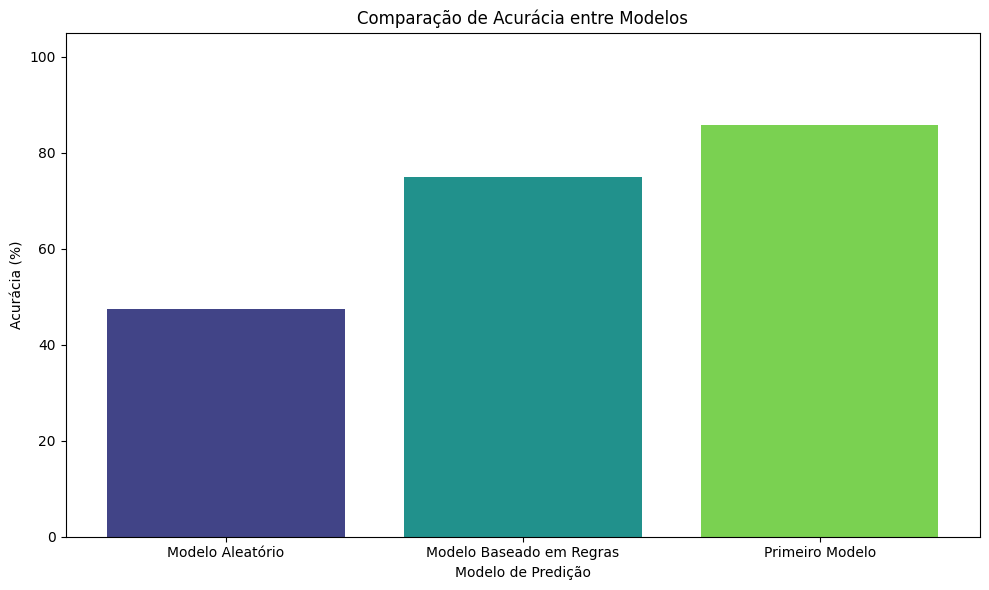

In [30]:
acuracias_dos_modelos = {
    'Modelo Aleatório': acc_aleatorio,
    'Modelo Baseado em Regras': acc_regras,
    'Primeiro Modelo': acc_lr
}

plot_model_comparison(acuracias_dos_modelos)

## Random Forest

Criaremos um segundo modelo diferente da Regressão Logística, usando dessa vez o Random Forest e vamos em sequência avaliá-lo.

O **Random Forest** constrói uma "floresta" de árvores de decisão, desse modo, cada árvore faz uma previsão de forma individual. O resultado final é a média das previsões de todas as árvores (para regressão) ou a previsão mais votada pela maioria das árvores (para classificação).

**Observação**: se necessário podemos usar a documentação do sklearn para ver os modelos disponíveis: [https://scikit-learn.org/stable/supervised_learning.html](https://scikit-learn.org/stable/supervised_learning.html)

--------------
Acurácia: 1.0
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       333
           1       1.00      1.00      1.00       401

    accuracy                           1.00       734
   macro avg       1.00      1.00      1.00       734
weighted avg       1.00      1.00      1.00       734



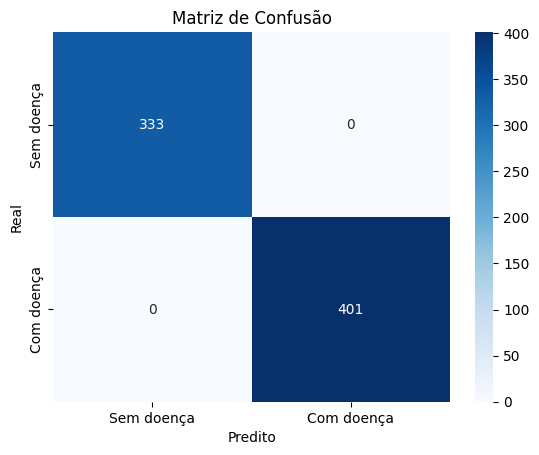

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# -----------------------------
# 1) Seleciona features e alvo
# -----------------------------
features = [
    'Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol',
    'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina',
    'Oldpeak', 'ST_Slope'
]
X = df[features].copy()
y = df['HeartDisease'].copy()

# -----------------------------
# 2) Define tipos de colunas
# -----------------------------
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
# numéricas “cruas” (sem normalização) — aqui só o binário FastingBS
numerical_cols = ['FastingBS']
# numéricas normalizadas 
numerical_cols_normalized = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# -----------------------------
# 3) Pré-processamento
# -----------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('num_normalized', MinMaxScaler(), numerical_cols_normalized),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ]
)

# -----------------------------
# 4) Pipeline + modelo
# -----------------------------
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=22, n_estimators=300))
])

# -----------------------------
# 5) Treino e avaliação 
# -----------------------------
model_rf.fit(X, y)
y_pred_rf = model_rf.predict(X)

print('--------------')
acc_rf = evaluate_classification(y, y_pred_rf)


### Importancia das variáveis


Importância das Características:
              Feature  Importance
19        ST_Slope_Up    0.138514
18      ST_Slope_Flat    0.106287
5             Oldpeak    0.092461
4               MaxHR    0.092203
3         Cholesterol    0.089129
16   ExerciseAngina_Y    0.080666
1                 Age    0.078248
2           RestingBP    0.064377
8   ChestPainType_ASY    0.058527
15   ExerciseAngina_N    0.055114
6               Sex_F    0.023008
7               Sex_M    0.022492
9   ChestPainType_ATA    0.021224
0           FastingBS    0.020550
10  ChestPainType_NAP    0.013034
12     RestingECG_LVH    0.012566
13  RestingECG_Normal    0.011576
14      RestingECG_ST    0.008769
17      ST_Slope_Down    0.006466
11   ChestPainType_TA    0.004790


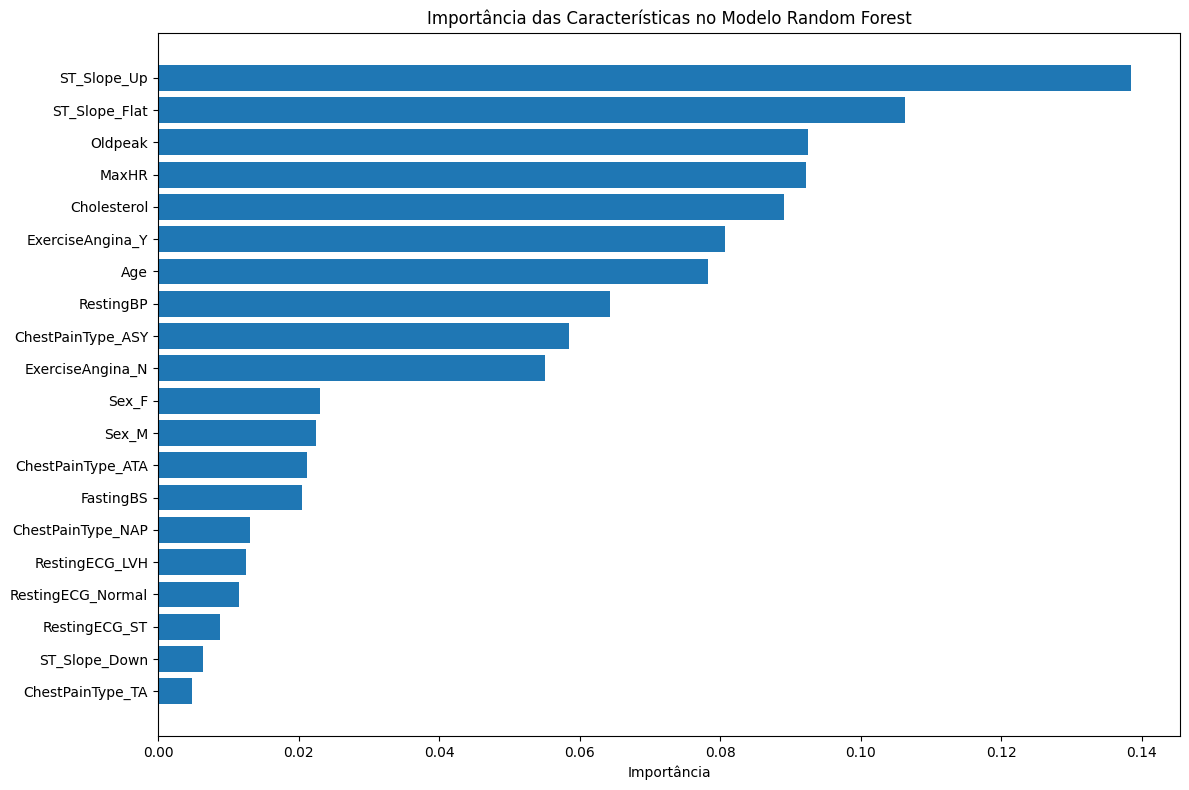

In [32]:
# Extrair os nomes das características após a transformação
def get_feature_names(column_transformer):
    """Obtém os nomes das características de todos os transformadores."""
    output_features = []

    for name, pipe, columns in column_transformer.transformers_:
        if name == 'num':
            output_features.extend(columns)
        elif name == 'num_normalized':
            output_features.extend(columns)
        elif name == 'cat':
            # Para colunas categóricas, obtém os nomes das características one-hot encoded
            if hasattr(pipe, 'get_feature_names_out'):
                encoder_features = pipe.get_feature_names_out(columns)
                output_features.extend(encoder_features)

    return output_features

# Obter os nomes das características
feature_names = get_feature_names(model_rf.named_steps['preprocessor'])

# Obter o modelo Random Forest do pipeline
rf_model = model_rf.named_steps['classifier']

# Criar um DataFrame com os nomes das características e suas importâncias
feature_importance_rf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
})

# Ordenar por importância
feature_importance_sorted = feature_importance_rf.sort_values('Importance', ascending=False)

# Imprimir a importância das características
print("\nImportância das Características:")
print(feature_importance_sorted)

# Plotar a importância das características
plt.figure(figsize=(12, 8))
feature_importance_plot = feature_importance_sorted.sort_values('Importance', ascending=True)
plt.barh(feature_importance_plot['Feature'], feature_importance_plot['Importance'])
plt.title('Importância das Características no Modelo Random Forest')
plt.xlabel('Importância')
plt.tight_layout()
plt.show()

Tabela de Comparação de Modelos:
                  Modelo  Acurácia  Acurácia (%)
        Modelo Aleatório  0.474114     47.411444
Modelo Baseado em Regras  0.749319     74.931880
         Primeiro Modelo  0.856948     85.694823
          Segundo Modelo  1.000000    100.000000


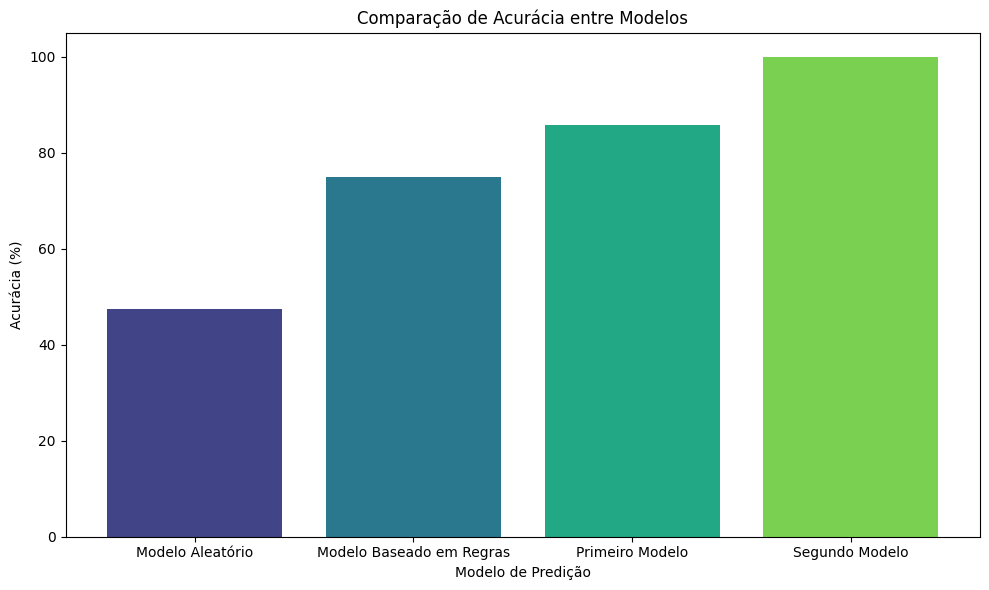

In [33]:
# Adiciona o novo modelo ao dicionário já definido anteriormente na primeira comparação
acuracias_dos_modelos['Segundo Modelo'] = acc_rf

plot_model_comparison(acuracias_dos_modelos)

## Utilizando os dados de teste 

### Modelo aleatório

Acurácia: 0.5434782608695652
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.47      0.62      0.53        77
           1       0.64      0.49      0.55       107

    accuracy                           0.54       184
   macro avg       0.55      0.55      0.54       184
weighted avg       0.57      0.54      0.54       184



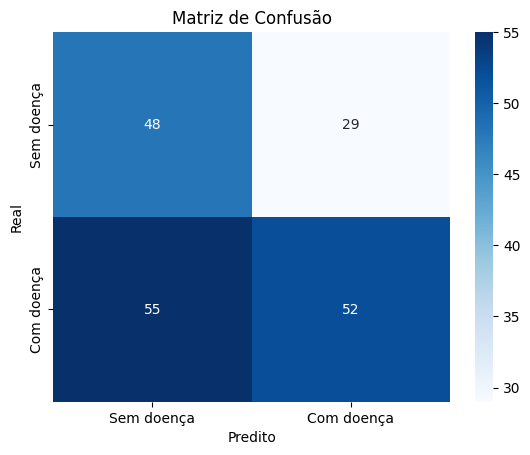

In [34]:
# Preparando os dados de teste
X_test = df_test.drop(['HeartDisease'], axis=1)
y_test = df_test['HeartDisease']

# Define a lista de elementos
elements = y_test.unique()

# Define o tamanho do vetor aleatório
vector_length = len(y_test)

# Gera o vetor aleatório
y_pred_baseline_test = np.random.choice(elements, size=vector_length)

# Avalia e salva a acurácia do modelo aleatório no conjunto de teste
acc_aleatorio_test = evaluate_classification(y_test, y_pred_baseline_test)

### Modelo baseado em regras 

Acurácia: 0.8043478260869565
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.73      0.84      0.78        77
           1       0.87      0.78      0.82       107

    accuracy                           0.80       184
   macro avg       0.80      0.81      0.80       184
weighted avg       0.81      0.80      0.81       184



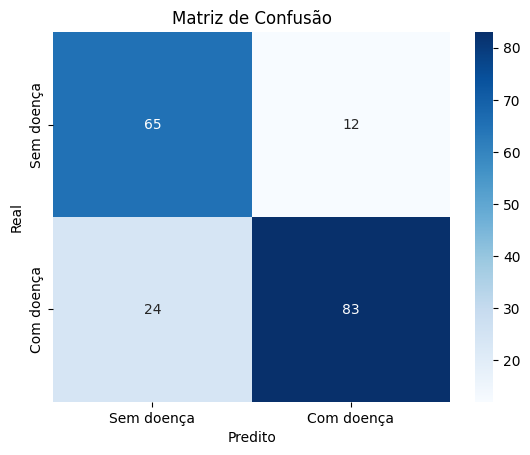

In [35]:
# Gera as predições
y_pred_pain_type_test = predict_by_pain_type(X_test)

# Avalia as predições
acc_regras_test = evaluate_classification(y_test, y_pred_pain_type_test)

### Rgressão Logística

--------------
Acurácia: 0.8315217391304348
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.76      0.88      0.81        77
           1       0.90      0.79      0.85       107

    accuracy                           0.83       184
   macro avg       0.83      0.84      0.83       184
weighted avg       0.84      0.83      0.83       184



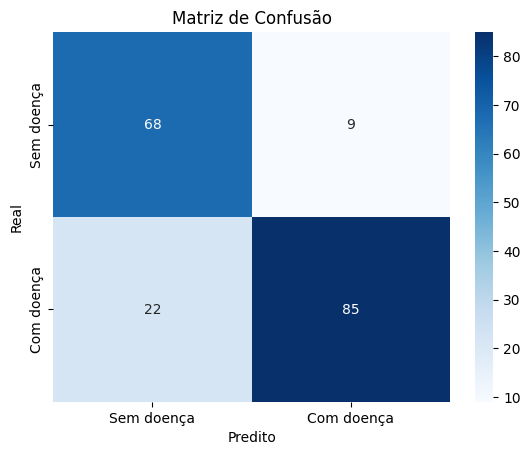

In [36]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

# --- mesmas listas do treino ---
features = [
    'Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol',
    'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina',
    'Oldpeak', 'ST_Slope'
]
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
cat_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# 1) Seleciona do df_test
X_test = df_test[features].copy()
y_test = df_test['HeartDisease'].copy()

# 2) Numéricas -> mediana 
num_imputer_test = SimpleImputer(strategy='median')
X_test[num_cols] = num_imputer_test.fit_transform(X_test[num_cols])

# 3) Categóricas -> modo (no TESTE)
for c in cat_cols:
    X_test[c] = X_test[c].fillna(X_test[c].mode()[0])

# 4) LabelEncoder 
encoders_test = {}
for c in cat_cols:
    le_t = LabelEncoder()
    X_test[c] = le_t.fit_transform(X_test[c])
    encoders_test[c] = le_t

# 5) Min-Max nas numéricas 
scaler_test = MinMaxScaler()
X_test[num_cols] = scaler_test.fit_transform(X_test[num_cols])

# 6) Predição com o modelo já treinado
y_pred_lr_test = model_lr.predict(X_test)

# 7) Avaliação
print('--------------')
acc_lr_test = evaluate_classification(y_test, y_pred_lr_test)


### Random Forest

Acurácia: 0.8804347826086957
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        77
           1       0.90      0.89      0.90       107

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



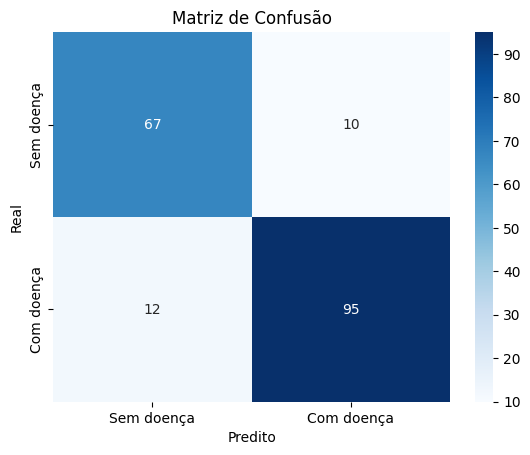

In [37]:
X_test = df_test.drop(columns=['HeartDisease'])
y_test = df_test['HeartDisease']

# Vamos utilizar o segundo modelo aqui para fazer a previsão
y_pred_test = model_rf.predict(X_test)

acc_rf_test = evaluate_classification(y_test, y_pred_test)

### Comparação entre os modelos

Tabela de Comparação de Modelos:
                        Modelo  Acurácia  Acurácia (%)
        Modelo Aleatório Teste  0.543478     54.347826
Modelo Baseado em Regras Teste  0.804348     80.434783
         Primeiro Modelo Teste  0.831522     83.152174
          Segundo Modelo Teste  0.880435     88.043478


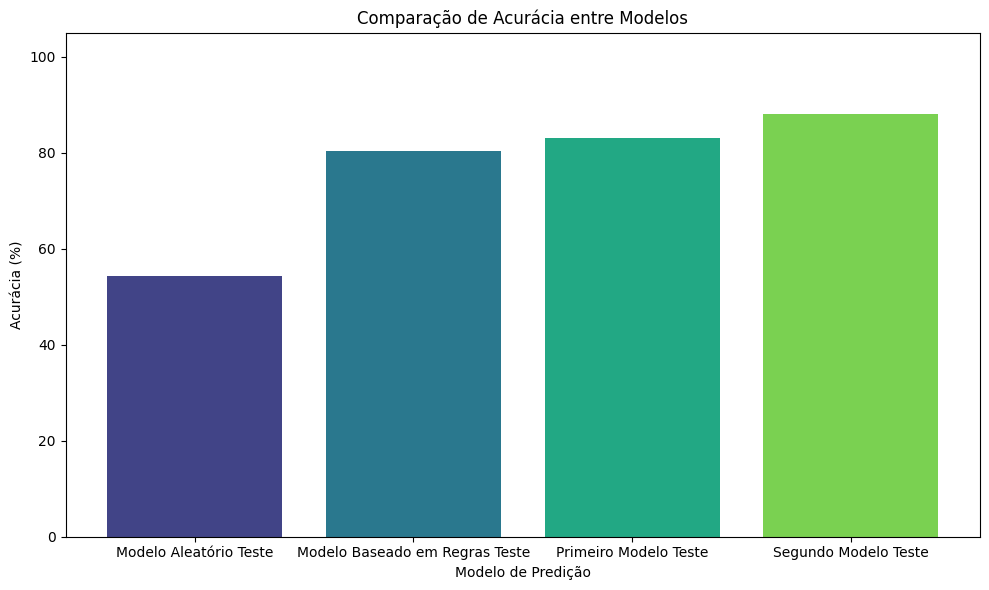

In [38]:
acuracias_dos_modelos_test = {
    'Modelo Aleatório Teste': acc_aleatorio_test,
    'Modelo Baseado em Regras Teste': acc_regras_test,
    'Primeiro Modelo Teste': acc_lr_test,
    'Segundo Modelo Teste': acc_rf_test
}

plot_model_comparison(acuracias_dos_modelos_test)